In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTENC,ADASYN
from sklearn.metrics import precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## 5. Random Forest

Para hacer uso del modelo Random Forest, nuevamente importamos el dataframe limpio del EDA.

In [3]:
df_final = pd.read_pickle("data_limpia.pkl") 

Seguiremos haciendo uso del esquema visto en la regresión logística para presentar resultados: primero veremos el modelo sin balanceo de clases, luego, y como este modelo es compatible con el parámetro `class_weight='balanced'`, haremos uso de el también, y por último los métodos ya usados `SMOTE` y `ADASYN`.

Empecemos entonces con el modelo sin balanceo de clases.

### 5.1 Modelo sin balanceo de clases

#### 5.1.1 Búsqueda del mejor parámetro
Primero, dividamos el dataset en las características y la variable objetivo:

In [4]:
X=df_final.drop(columns=['target'])
y=df_final['target']

Codificamos la variable objetivo:

In [5]:
y = y.map({
    'diseased': 1,
    'healthy': 0,
})

# Verificamos la codificación
print(y.value_counts())

target
0    70097
1    29903
Name: count, dtype: int64


Dividamos el dataset en un conjunto de entrenamiento y otro de prueba. Este último se reservará **únicamente para la evaluación del modelo con el mejor parámetro encontrado**. Para la búsqueda del mejor parámetro, se usará el conjunto de entrenamiento dividido en entrenamiento y validación.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Ahora, mediante el uso de `pipelines` y la función `GridSearchCV`, buscaremos los parámetros: el mejor número de árboles y la mejor profundidad máxima de los mismos para encontrar el mejor score.

In [7]:
numerical_cols=['age', 'bmi','waist_size',
    'blood_pressure', 'cholesterol', 'heart_rate',
    'glucose', 'insulin','sleep_hours','work_hours','physical_activity','daily_steps',
    'calorie_intake', 'sugar_intake','water_intake','income',
    'screen_time', 'stress_level', 'mental_health_score', 'meals_per_day']

cat_cols=['gender', 'diet_type', 'occupation',
    'sleep_quality', 'mental_health_support', 'exercise_type',
    'device_usage', 'healthcare_access', 'insurance',
    'family_history', 'sunlight_exposure', 'alcohol_consumption', 
    'smoking_level', 'education_level', 'job_type', 'caffeine_intake', 'pet_owner']

In [40]:
preprocessor=ColumnTransformer( 
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough" # Mantener las columnas numéricas sin cambios
)

pipe=Pipeline([
    ("preprocessor", preprocessor),
    ("random_forest", RandomForestClassifier(random_state=42))
    
])

param_grid_pipe={
    "random_forest__n_estimators": [10, 50, 100],
    "random_forest__max_depth": [5,10,15]
}

En el `pipeline` se implementó un `ColumnTransformer` para realizar la codificación de las variables categóricas, ya que no es necesaria una estandarización de las numéricas con este modelo, dentro de cada división del `GridSearchCV`, y a su vez se buscarán los mejores resultados obtenidos variando la profundida máxima de los árboles y el número de árboles usados.

In [41]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1, verbose=1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Tiempo de ejecucion(segundos):107.92


Veamos ahora los mejores parámetros conseguidos por `GridSearchCV`:

In [42]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'random_forest__max_depth': 15, 'random_forest__n_estimators': 10}
Best cross-validation score: 0.01


Como podemos ver en el mejor score, calculado con la métrica `recall`, si no consideramos el uso de ningún balanceo de clases, el modelo logístico no tiene la capacidad de clasificar **ninguna** observación como perteneciente a un individuo **enfermo**. Comprobemos esta suposición entrenando un modelo con los "mejores" parámetros conseguidos, evaluándolo en el conjunto de test reservado anteriormente y calculando su matriz de confusión, un reporte de clasificación y curvas `precision-recall` y `ROC`.

#### 5.1.2 Implementación del modelo con el mejor parámetro y métricas de evaluación

Usando el atributo `best_estimator_` conseguimos la mejor combinación de parámetros conseguida en el `GridSearchCV` para poder evaluarlos en el conjunto de test.

In [43]:
best_model = grid_pipe.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased']))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy       0.70      1.00      0.82     17524
    diseased       0.27      0.00      0.01      7476

    accuracy                           0.70     25000
   macro avg       0.49      0.50      0.42     25000
weighted avg       0.57      0.70      0.58     25000



Del reporte de clasificación obtenemos lo siguiente:

- **`healthy` como clase positiva**: Debido al desbalance de clases, el modelo solo aprendió a predecir `healthy`, esto lo demuestran los resultados de las métricas `precision=0.7`, que indica que del total de positivos predichos por el modelo el 70% fue correcto, y `recall=1.0`, la cual indica que clasificó correctamente todos los positivos del conjunto de test.

- **`diseased` como clase positiva**: El hecho de que todos los scores de las métricas `precision`, `recall` y `f1-score` sean 0 indica que el modelo **no cuenta** con la capacidad de detectar la clase `diseased`.

- **`accuracy` engañoso**: El resultado de `accuracy` nos indica que no debemos usar esta métrica para evaluar los modelos, ya que ingenuamente podriamos decir que tiene un rendimiento bueno de 0.7, pero las otras métricas nos enseñan que no está clasificando como es debido.

Veamos la matriz de confusión del modelo para verificar cómo se están realizando las predicciones en el modelo.

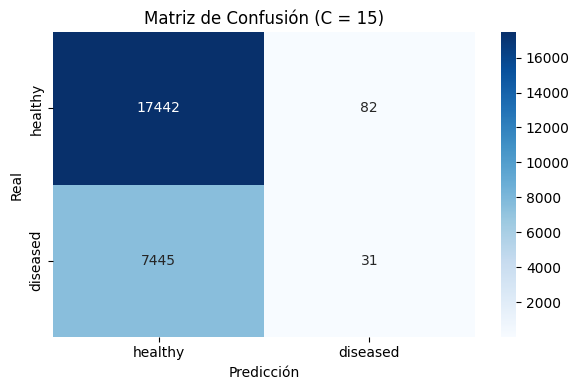

In [44]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

Gracias a esta matriz verificamos que el modelo logístico sin balanceo no clasifica a **ninguna observación** como `diseased`. Esto puede deberse al desbalance de clases del dataset, como también a la baja variabilidad de las características dependiendo de su clase en la variable objetivo como vimos en el EDA.

Veamos ahora la curva `precision_recall`:

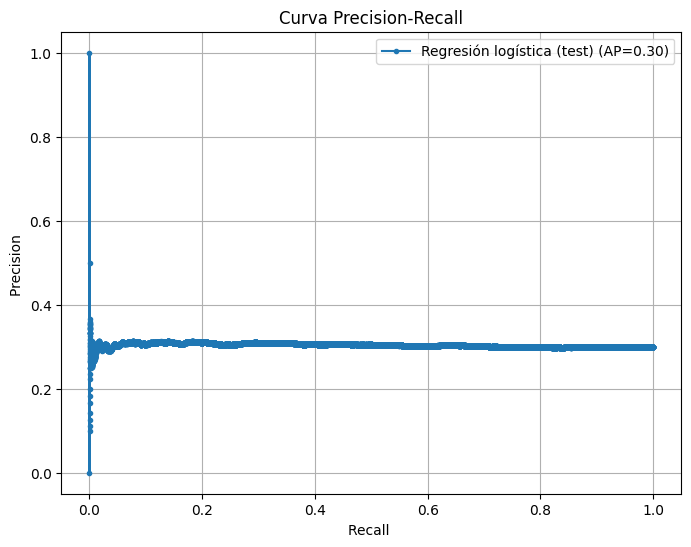

In [45]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'Regresión logística (test) (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

Como podemos ver en el gráfico, no hay ningún umbral que ofrezca un buen balance entre las métricas `precision` y `recall`. Mientras el `recall` aumenta, `precision` queda constante en un valor de aproximadamente 0.3. Esto sugiere que aunque cambiemos el umbral y aumente la detección de positivos reales, la proporción de positivos predichos por el modelo siempre va a ser baja, es decir, el modelo estaría arrojando muchos falsos positivos.

Y ahora la curva `ROC`:

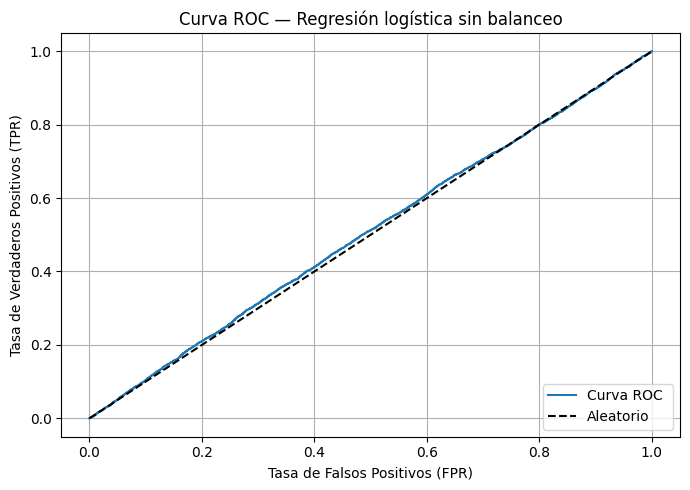

AUC (Área bajo la curva ROC): 0.5066


In [46]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — Regresión logística sin balanceo')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

Así mismo tenemos la curva `ROC`, que en este caso se encuentra sobre la diagonal que representa un modelo completamente aleatorio, y el `AUC=0.5` que representa que el modelo tiene un 50% de probabilidades de asignar una probabilidad mayor a la clase positiva que a la clase negativa, es decir, también es aleatorio. Estos resultados se deben a que, como lo vimos en el EDA al comparar las variables dependiendo de si pertenecian a la clase `diseased` o no, no se encontraron muchas diferencias para cada variable, por lo que esto puede dificultar la capacidad predicitiva de un modelo no tan complejo como lo es la regresión logística.

#### 5.1.3 Conclusiones del modelo

Aunque el desbalance de clases no es tan grande (70/30), el hecho de que las características no ofrezcan a simple vista una diferencia clara entre las clases de la variable objetivo hace que este modelo al no ser tan complejo no sea capaz de distinguir entre clases, y al tener más información de la clase `healthy`, termina clasificando todas las observaciones como `healthy`. 

Comparemos ahora el rendimiento del modelo logístico usando distintos tipos de balanceo de clases, comenzando por el parámetro `class_weight='balanced'` con el que viene implementado `LogisticRegression`.

### 5.2 Modelo con balanceo por el parámetro `class_weight='balanced'`

El parámetro `class_weight='balanced'` nos permite asignarle pesos a las clases de la variable objetivo en la función de pérdida del modelo, con el fin de darle un mayor peso a la clase minoritaria y menos a la mayoritaria.

#### 5.2.1 Búsqueda del mejor parámetro

In [47]:
preprocessor=ColumnTransformer( 
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough" # Mantener las columnas numéricas sin cambios
)

pipe=Pipeline([
    ("preprocessor", preprocessor),
    ("random_forest", RandomForestClassifier(random_state=42,class_weight='balanced')) #Incluimos el parámetro class_weight= 'balanced
    
])

param_grid_pipe={
    "random_forest__n_estimators": [10, 50, 100],
    "random_forest__max_depth": [5,10,15]
}

Veamos nuevamente la búsqueda de los mejores parámetros por medio de `GridSearchCV`:

In [49]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

Tiempo de ejecucion(segundos):117.95


Veamos ahora los mejores parámetros conseguidos por `GridSearchCV`:

In [50]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'random_forest__max_depth': 5, 'random_forest__n_estimators': 10}
Best cross-validation score: 0.50


Con el parámetro `C=0.1` y usando la regularización L2 obtuvimos un score de `recall=0.49` el cual es una notoria mejora con respecto al modelo sin balanceo de clases, que obtuvo un `recall=0`, lo que indica que con el balanceo el modelo pudo diferenciar mejor entre clases y no clasificar a todas las observaciones para una sola como ocurrió en la versión sin balanceo.

Sin embargo sigue siendo un desempeño pobre que no supera al azar. Veamos el modelo entrenado con el conjunto `X_train` y evaluado en el conjunto de test reservado, usando los mejores parámetros encontrados.

#### 5.2.2 Implementación del modelo con el mejor parámetro y métricas de evaluación

Usando el atributo `best_estimator_` conseguimos la mejor combinación de parámetros conseguida en el `GridSearchCV` para poder evaluarlos en el conjunto de test.

In [51]:
best_model = grid_pipe.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased']))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy       0.70      0.54      0.61     17524
    diseased       0.30      0.46      0.36      7476

    accuracy                           0.52     25000
   macro avg       0.50      0.50      0.49     25000
weighted avg       0.58      0.52      0.54     25000



- **`healthy` como clase positiva**: Si bien el 70% de las predicciones de `healthy` en el modelo fueron correctas, solo se clasificó bien aproximadamente el 51% de las observaciones del conjunto de test.

- **`diseased` como clase positiva**: En cambio la clase `diseased`, la cual es la que estamos considerando en general como positiva, sigue teniendo scores muy pobres, `precision=0.3` y `recall=0.5`.

- **`accuracy`**: A diferencia del modelo anterior, un `accuracy=0.51` nos indica que el modelo solo clasificó bien a la mitad de las observaciones aproximadamente.

Veamos como fueron en si estas clasificaciones con la matriz de confusión:

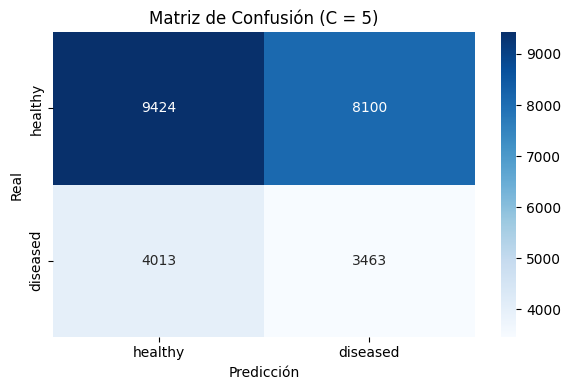

In [52]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

Como se dijo anteriormente, el modelo ya no clasifica a una sola clase como en la versión sin balanceo, pero tiene dificultades para diferenciar ambas clases de la variable objetivo.

Veamos ahora las curvas `precision_recall` y `ROC`:

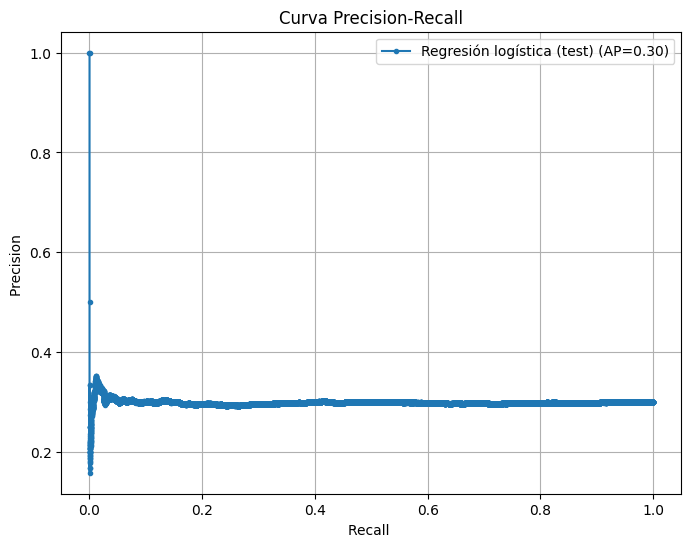

In [53]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'Regresión logística (test) (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

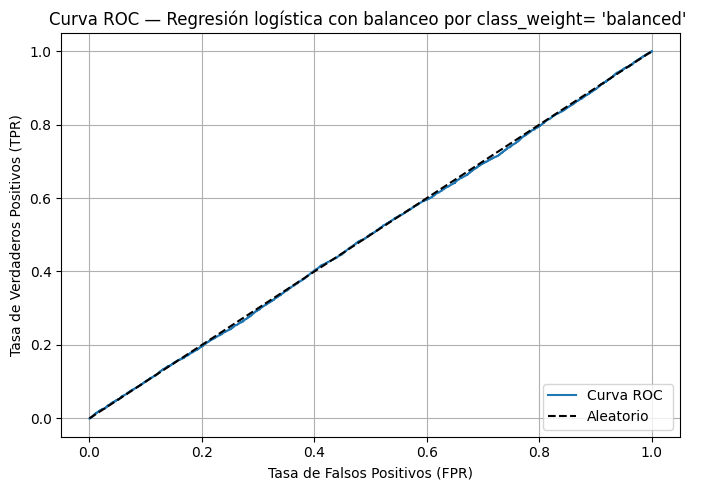

AUC (Área bajo la curva ROC): 0.4978


In [54]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — Regresión logística con balanceo por class_weight= '"'balanced'"' ')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

Como podemos ver, ambas curvas son similares a las obtenidas en el modelo sin balancear, por lo que variar el umbral sigue sin ofrecer cambios significativos a los scores del modelo.

#### 5.2.3 Conclusiones del modelo

Si bien al introducir este balanceo se obtuvieron mejoras comparadas con la versión sin este, la predicción de ambas clases sigue siendo mala aún teniendo en cuenta que al usar `recall` como métrica principal y priorizando la disminución de falsos negativos aunque los falsos positivos sean una molestia.

### 5.3 Modelo con balanceo por SMOTE

En el caso de este dataset, contamos tanto con variables numéricas como con variables categóricas, así que decidimos usar `SMOTENC` que es una variante del `SMOTE` original que ofrece `imblearn` para conjuntos de datos que cuenten con variables númericas y categóricas, como es nuestro caso.

Para poder indicarle a `SMOTENC` cuales son las variables categóricas, necesitamos pasarle los índices de las columnas en donde se encuentran:

In [28]:
cat_cols_indices = [X_train.columns.get_loc(col) for col in cat_cols]
cat_cols_indices

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

Además, para poder implementar el `SMOTENC` en un `pipeline` debemos importar el `Pipeline` de `imblearn`

In [32]:
from imblearn.pipeline import Pipeline


postsmote = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_indices)
    ],
    remainder="passthrough" # Mantener las columnas numéricas sin cambios
)

pipe=Pipeline([
    ('smote', SMOTENC(categorical_features=cat_cols_indices, random_state=42, n_jobs=-1)),
    ("post_smote", postsmote),
    ("random_forest", RandomForestClassifier(random_state=42))
])


param_grid_pipe={
    "random_forest__n_estimators": [10, 50, 100],
    "random_forest__max_depth": [5,10,15]
}

#### 2.3.1 Busqúeda de los mejores parámetros

In [33]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

  File "c:\Users\Hector\miniconda3\envs\ml_venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Hector\miniconda3\envs\ml_venv\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Hector\miniconda3\envs\ml_venv\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Hector\miniconda3\envs\ml_venv\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Tiempo de ejecucion(segundos):1964.61


Veamos ahora los mejores parámetros conseguidos por `GridSearchCV`:

In [34]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'random_forest__max_depth': 5, 'random_forest__n_estimators': 100}
Best cross-validation score: 0.49


El mejor `C` conseguido por `GridSearchCV` fue de `10`, usando la regularización L2. Se consiguió un `recall=0.55` que es un poco mayor al conseguido con el parámetro `class_weight='balanced'`. Veamos ahora el modelo entrenado con `X_train` y `y_train` y evaluado en `X_test` y `y_test`.

#### 2.3.2 Implementación del modelo con el mejor parámetro y métricas de evaluación

In [35]:
best_model = grid_pipe.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased']))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy       0.70      0.49      0.58     17524
    diseased       0.30      0.52      0.38      7476

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.48     25000
weighted avg       0.58      0.50      0.52     25000



Del reporte de clasificación obtenemos lo siguiente:

- **`healthy` como clase positiva**: Si bien el 70% de las predicciones de `healthy` en el modelo fueron correctas, solo se clasificó bien aproximadamente el 42% de las observaciones del conjunto de test.

- **`diseased` como clase positiva**: En cambio la clase `diseased`, la cual es la que estamos considerando en general como positiva, mejoró un poco con respecto al modelo anterior: `precision=0.3` y `recall=0.57`. Quiere decir que luego del balanceo, se está clasificando más a la clase positiva que a la negativa pero hay muchos falsos positivos. **El modelo está prediciendo mayor cantidad de positivos reales pero a su vez clasificando a muchas observaciones como positivas, por lo que `precision` baja.**

- **`accuracy`**: Este modelo nos arroja un `accuracy=0.46`, lo que indica que el total de clasificaciones correctas empeoró con respecto a los dos modelos anteriores.

Verifiquemos estos análisis con la matriz de confusión:

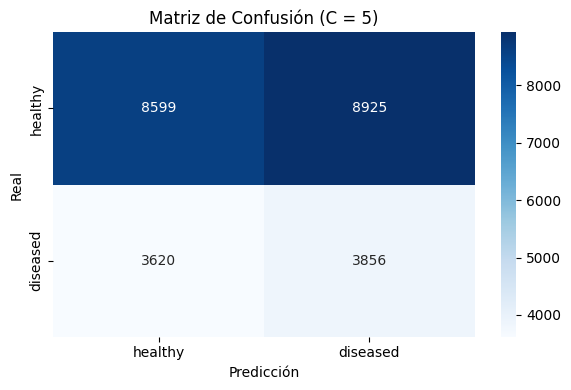

In [36]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

Como se anticipó en el análisis del reporte de clasificación, se obtuvo una mayor cantidad de positivos reales pero teniendo una gran cantidad de falsos positivos.

Veamos ahora la curva `precision_recall`:

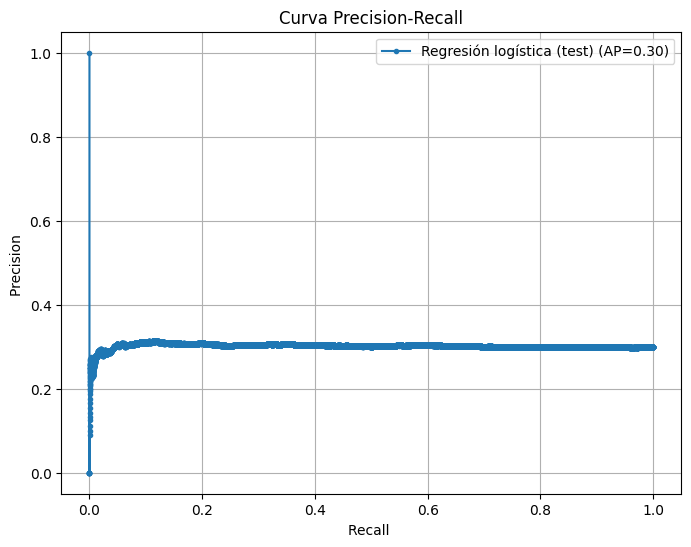

In [37]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'Regresión logística (test) (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

Esta curva sigue teniendo un comportamiento similar al ya visto en los anteriores modelos. No tenemos aún un balance positivo entre `precision` y `recall`. Si cambiamos el umbral para detectar una mayor cantidad de positivos reales, terminamos obteniendo muchos falsos positivos, por lo que `precision` no tiene un valor favorable.

Por otro lado tenemos la curva `ROC`:

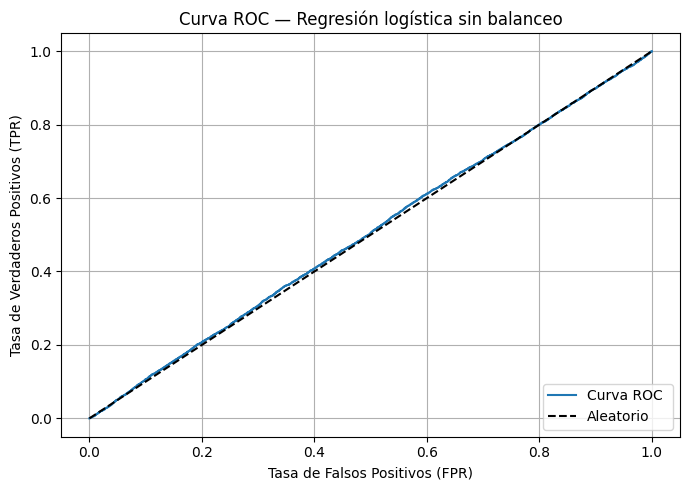

AUC (Área bajo la curva ROC): 0.5046


In [38]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — Regresión logística sin balanceo')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

Esta curva y su respectivo `AUC` no mejoraron con respecto a los modelos anteriores, incluso empeoraron, lo que ya nos hace considerar que del modelo logístico no vamos a obtener muy buenos resultados.

#### 2.3.3 Conclusiones del modelo

Vimos un ligero aumento en el `recall`, sin embargo siguen siendo muy malos scores y el hecho de cambiar el umbral, como lo vimos en las curvas `precision-recall` y `ROC` no ayuda tanto a la generalización.

Por último veamos un balanceo con `ADASYN` antes de pasar al siguiente modelo.

### 2.4. Modelo con balanceo por ADASYN

El ADASYN (Adaptive Synthetic Sampling) extiende SMOTE, pero se enfoca en ejemplos minoritarios más difíciles de aprender.

Lastimosamente ADASYN no cuenta con una versión que maneje las variables categóricas como si lo hacía SMOTE, por lo que simplemente se hará una estandarización y una codificación de las variables numéricas y categóricas respectivamente, para luego hacer uso del método.

In [ ]:
from imblearn.pipeline import Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough" # Mantener las columnas numéricas sin cambios
)

pipe=Pipeline([
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42, n_jobs=-1)),
    ("random_forest", RandomForestClassifier(random_state=42))
])


param_grid_pipe={
    "random_forest__n_estimators": [10, 50, 100],
    "random_forest__max_depth": [5,10,15]
}

#### 2.4.1 Búsqueda del mejor parámetro

In [64]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

Tiempo de ejecucion(segundos):316.92


Veamos ahora los mejores parámetros conseguidos por `GridSearchCV`:

In [65]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'random_forest__max_depth': 15, 'random_forest__n_estimators': 10}
Best cross-validation score: 0.02


El mejor score de `recall` obtenido por `GridSearchCV` fue usando `C=0.01` y regularización L2. Con este balanceo vemos que obtuvimos un score de 0.82. Veamos ahora la generalización con el conjunto de test, entrenada con el conjunto de train.

#### 2.4.2 Implementación del modelo con el mejor parámetro y métricas de evaluación

In [66]:
best_model = grid_pipe.best_estimator_

# Reentrenar con el X_train completo
best_model.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['healthy', 'diseased']))



 Reporte de clasificación:
              precision    recall  f1-score   support

     healthy       0.70      0.98      0.82     17524
    diseased       0.26      0.02      0.03      7476

    accuracy                           0.69     25000
   macro avg       0.48      0.50      0.42     25000
weighted avg       0.57      0.69      0.58     25000



Del reporte de clasificación obtenemos lo siguiente:

- **`healthy` como clase positiva**: Si bien el 70% de las predicciones de `healthy` en el modelo fueron correctas, solo se clasificó bien aproximadamente el 14% de las observaciones del conjunto de test, una disminución bastante grande con respecto a las versiones anteriores de este modelo. Esto quiere decir que si bien la proporción de clasificaciones del modelo de la clase `healthy` es buena, en todo el conjunto de test apenas y clasificó bien esta clase.

- **`diseased` como clase positiva**: En cambio la clase `diseased`, la cual es la que estamos considerando en general como positiva, mejoró bastante con respecto al modelo anterior: `precision=0.3` y `recall=0.82`. Quiere decir que luego del balanceo, se está clasificando más a la clase positiva que a la negativa pero hay muchos falsos positivos. **El modelo está prediciendo mayor cantidad de positivos reales pero a su vez clasificando a muchas observaciones como positivas, por lo que `precision` baja.**

- **`accuracy`**: Este modelo nos arroja un `accuracy=0.34`, lo que indica que el total de clasificaciones correctas empeoró con respecto a los tres modelos anteriores.

Veamos la matriz de confusión para verificar este análisis.

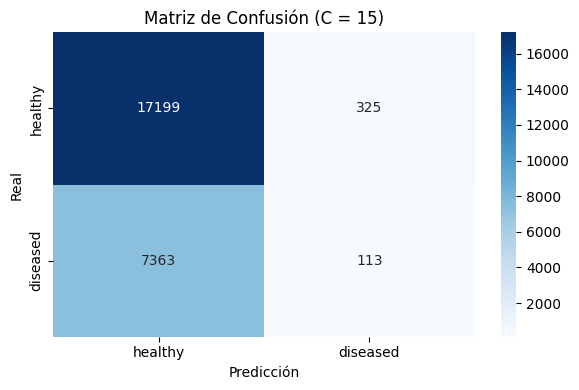

In [67]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['healthy', 'diseased'],
            yticklabels=['healthy', 'diseased'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (C = {list(grid_pipe.best_params_.values())[0]})")
plt.tight_layout()
plt.show()

Como podemos ver, una gran parte de las clasificaciones fueron a parar a la clase positiva, lo cual es razonable ya que se aumentó su número de registros en el dataset con observaciones sintéticas. Sin embargo, al clasificar tantas observaciones como `diseased`, terminamos obteniendo demasiados falsos positivos y a su vez bastantes buenas clasificaciones en el conjunto de test.

Veamos ahora las curvas `precision_recall` y `ROC`:

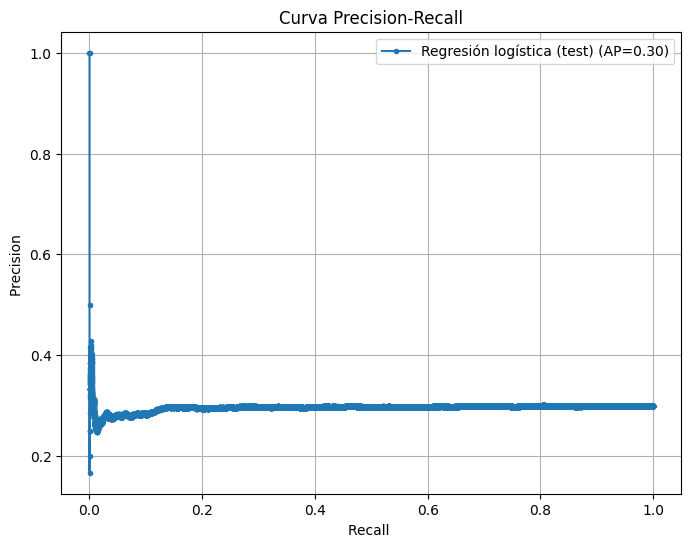

In [68]:
# Calcular precision y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular promedio (Average Precision Score)
avg_precision = average_precision_score(y_test, y_proba)

# Graficar curva Precision-Recall
plt.figure(figsize=(8,6)) 
plt.plot(recall, precision, marker='.', label=f'Regresión logística (test) (AP={avg_precision:.2f})')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

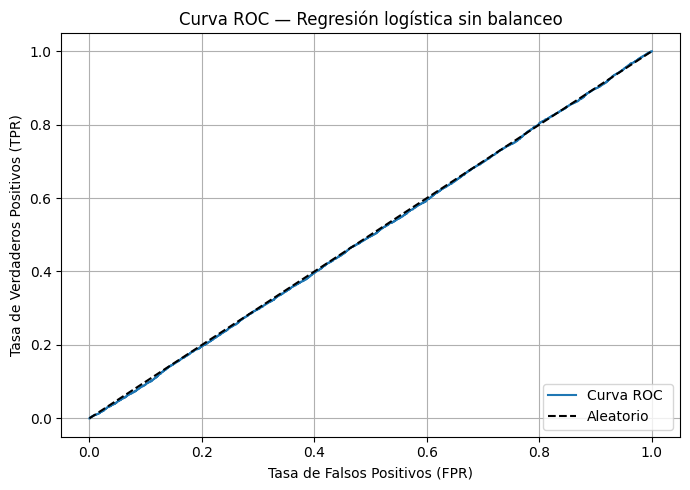

AUC (Área bajo la curva ROC): 0.4974


In [69]:

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC — Regresión logística sin balanceo')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

En ambas curvas se obtuvieron resultados similares a las versiones anteriores del modelo logístico.

#### 2.4.3 Conclusiones del modelo

Si bien obtuvimos el mejor resultado de `recall` que con los otros balanceos, la generalización del modelo es algo pobre ya que está clasificando a muchas observaciones como `diseased` por lo que es esperable que el score de esta métrica sea alto, pero corremos el riesgo de diagnosticar a demasiadas personas como enfermas cuando en realidad están sanas.

### 2.5 Conclusiones generales del modelo de regresión logística

Los retos más difíciles a los que nos vamos a enfrentar en este proyecto son tanto el desbalance de la variable objetivo, como la poca variabilidad, valga la redundancia, de las variables siendo comparadas por el target. 

Este modelo nunca pudo diferenciar realmente bien entre las clases `healthy` y `diseased`. Primeramente, sin considerar ningún balanceo, todas las clasificaciones fueron a parar a la clase negativa, luego, al considerar agregarle más peso a la clase minoritaria, se pudo mejorar la clasificación, pero seguía siendo muy pobre. Por último los balanceos con SMOTE y ADASYN arrojaron mejores resultados, pero el modelo tendía a clasificar bastantes observaciones para la clase positiva.

Todo esto nos indica que las predicciones del modelo de regresión logística con este dataset dependieron de la cantidad de observaciones que se tenían de cada clase de la variable objetivo.

En la siguiente sección haremos uso del modelo `k-NN` con el objetivo de buscar mejores resultados que con la regresión logística.

In [79]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
preprocessor=ColumnTransformer( 
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough" # Mantener las columnas numéricas sin cambios
)

pipe=Pipeline([
    ("preprocessor", preprocessor),
    ("xgboost", XGBClassifier(random_state=42, verbosity=2, tree_method='gpu_hist'))
    
])

param_grid_pipe={
    'xgboost__max_depth': [1, 2, 3, 4, 5],  # Rango para la profundidad del árbol
    'xgboost__learning_rate': [0.1, 0.2, 0.3],  # Rango para la tasa de aprendizaje
    'xgboost__n_estimators': [10, 50, 100],  # Número de árboles a entrenar
}

In [80]:
start=time.time()
stratified_kfold = StratifiedKFold(n_splits=5)
grid_pipe=GridSearchCV(pipe, param_grid=param_grid_pipe, cv=stratified_kfold, scoring='recall', n_jobs=-1)
grid_pipe.fit(X_train, y_train)
end=time.time()
print(f"Tiempo de ejecucion(segundos):{(end-start):.2f}")

Tiempo de ejecucion(segundos):83.62


In [81]:
print("Best parameter: {}".format(grid_pipe.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_pipe.best_score_))

Best parameter: {'xgboost__learning_rate': 0.3, 'xgboost__max_depth': 5, 'xgboost__n_estimators': 100}
Best cross-validation score: 0.02
